In [1]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from iminuit import Minuit
import pandas as pd
import time 
from scipy.interpolate import interp1d
import math
import library

FileNotFoundError: [Errno 2] No such file or directory: 'fsigma8_data.dat'

In [ ]:
db_name = "pantheon.dat"
c = 299792.458

Zhd = library.make_ds(db_name,2)
MU_SHOES = library.make_ds(db_name,10)
IS_calib = library.make_ds(db_name,13)
ceph_dist = library.make_ds(db_name,12)
mb_corr = library.make_ds(db_name,8)

List = library.make_list("pantheoncov.cov")
n = 1701
def cov(List, n):
    # Redimensionner la liste en une matrice
    tab = np.array(List).reshape((n, n))
    return tab

# Exemple d'utilisation

Cov = cov(List, n)
Cov1 = np.linalg.inv(Cov)

#importation des donnés RSDs
df = pd.read_csv("fsigma8_data.dat", sep=";")

z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())


In [ ]:
def gamma(w,omega_m0,z):
    return   (3*(w-1))/(6*w-5) #- ((15/2057)*np.log(omega_m(z,omega_m0,w)))

def omega_m(z,omega_m0,w):
    return (omega_m0*(1/(omega_m0+(1-omega_m0)*(1+z)**(3*w))))

def omega_mGamma(z,gamma,omega_m0,w):
    return omega_m(z,omega_m0,w)**gamma

def func(z, omega_m0, w):
    return omega_mGamma(z, gamma(w, omega_m0, z), omega_m0, w) / (1 + z)

def D_z(omega_m0, z, w):
    result, _ = quad(func, 0, z, args=(omega_m0, w))
    return np.exp(-result)

def sigma8(sigma8_0, omega_m0, z, w):
    return sigma8_0 * np.array([D_z(omega_m0, zi, w) for zi in z])

def Chi2RSD(omega_m0, sigma8_0, w):
    sigma8_vals = sigma8(sigma8_0, omega_m0, z_data, w)
    pred = omega_mGamma(z_data, gamma(w, omega_m0, z_data), omega_m0, w) * sigma8_vals

    residuals = fsig8 - pred
    sigma_errors = np.where(residuals >= 0, fsig8_err_plus, fsig8_err_minus)
    chi2_terms = (residuals / sigma_errors) ** 2

    return np.sum(chi2_terms)

def f(z,H0,omega_m,w):

    a  = (H0*np.sqrt(omega_m*math.pow((1+z),3)+(1-omega_m)*(math.pow((1+z),3*(1+w)))))
    if a == 0:
        print("a = ",0)
    return 1/a

def Mu(z,H0,omega_m,w):
    
    #print(type(X))

    # Calculer l'intégrale numérique de la fonction f(x) en utilisant la méthode des trapèzes
    I,err = quad(f,0,z,args = (H0,omega_m,w))
    return 5*np.log10(((1+z)*c*I*(10**5)))

def Chi2Panth(H0,omega_m,w,M):
    
    chi2 = 0
    diffMu = np.array([])

    for i in range(0,len(Zhd)):
        if IS_calib[i] == 0:
            diffMu = np.append(diffMu,Mu(Zhd[i],H0,omega_m,w)-(mb_corr[i]-M))
        else:
            diffMu =  np.append(diffMu,(mb_corr[i]-M)-ceph_dist[i])
    
    return np.dot(np.dot(Cov1,diffMu),diffMu)

def Chi2(H0,omega_m0,M,sigma8_0,w):
    
    #start = time.time()
    res = Chi2RSD(omega_m0,sigma8_0,w)+Chi2Panth(H0,omega_m0,w,M)
    #end = time.time()
    #print("t = ",end-start,"s")
    #print("H0 = ",H0,"omega_m = ",omega_m0,"sig8_0",sigma8_0,"M =",M,"w = ",w)
    return res

In [ ]:
om_min = 0.2
om_max = 0.6
sig8_min = 0.2
sig8_max = 1
w_min = -2
w_max = -1/3

minimizer = Minuit(Chi2,H0 = 73.4,omega_m0 = 0.3,M=-19.25,sigma8_0 = 0.7 ,w = -1)
minimizer.limits["omega_m0"] = (om_min,om_max)
minimizer.limits["sigma8_0"] = (sig8_min,sig8_max)  # Valeurs plus physiques
minimizer.limits["w"] = (w_min,w_max)
minimizer.fixed["H0"] = True
minimizer.fixed["M"] = True
minimizer.errordef = 1.0  # Pour chi2

result = minimizer.migrad()
print(result)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1533                       │              Nfcn = 71               │
│ EDM = 7.1e-05 (Goal: 0.0002)     │            time = 7.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

In [ ]:
# Statistiques du fit
chi2_val = minimizer.fval
ndof = len(fsig8) - len(minimizer.parameters)
chi2_reduit = chi2_val / ndof

print(f"\nRésultats du fit :")
print(f"Chi2 = {chi2_val:.2f}")
print(f"Nombre de degrés de liberté = {ndof}")
print(f"Chi2 réduit = {chi2_reduit:.2f}")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega_m0']:.3f} ± {minimizer.errors['omega_m0']:.4f}")
print(f"σ8,0 = {minimizer.values['sigma8_0']:.3f} ± {minimizer.errors['sigma8_0']:.4f}")
#print(f"H0 = {minimizer.values['H0']:.3f} ± {minimizer.errors['H0']:.3f}")
#print(f"M = {minimizer.values['M']:.3f} ± {minimizer.errors['M']:.3f}")
print(f"w = {minimizer.values['w']:.3f} ± {minimizer.errors['w']:.3f}")


Résultats du fit :
Chi2 = 1532.90
Nombre de degrés de liberté = 18
Chi2 réduit = 85.16
Paramètres estimés :
Ωm = 0.311 ± 0.0407
σ8,0 = 0.785 ± 0.0415
w = -0.950 ± 0.084


<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_23604\1086088975.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


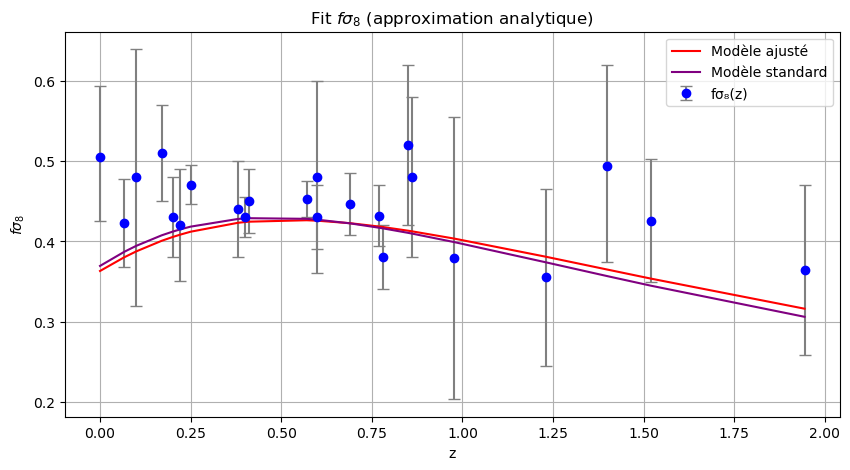

In [ ]:
omega_m0_fit = minimizer.values["omega_m0"]
sigma8_0_fit = minimizer.values["sigma8_0"]
w_fit = minimizer.values["w"]

om_ms = 0.334
S8_ms = 0.81
sig8_ms = S8_ms*(0.3/om_ms)**(0.5)
gamma_fit = gamma(omega_m0_fit,w_fit,z_data)
modele = omega_mGamma(z_data, gamma_fit, omega_m0_fit,w_fit) * np.array(library.sigma8(sigma8_0_fit, omega_m0_fit, z_data,w_fit))
gamma_modele_standard = gamma(om_ms, -1,z_data)
modele_standard = omega_mGamma(z_data, gamma_modele_standard, 0.334,-1) * np.array(library.sigma8(sig8_ms,om_ms,z_data,-1))

# --- Plot 1 : Fit et données ---
plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele, 'r-', label='Modèle ajusté')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)

In [ ]:
"""
def compute_grid_Chi2(om_vals, sig8_vals, w_vals):
    
    h0 = 73.4
    m = -19.25
    
    chi2_grid_om_sig8 = np.zeros((len(om_vals), len(sig8_vals)))
    chi2_grid_om_w = np.zeros((len(om_vals), len(w_vals)))
    chi2_grid_sig8_w = np.zeros((len(sig8_vals), len(w_vals)))

    # (1) Fix om & sig8, minimise w
    for i, om in enumerate(om_vals):
        for j, sig8 in enumerate(sig8_vals):
            #print("Om,sig8 = ",om,sig8)
            minimizer = Minuit(Chi2,H0=h0,omega_m0=om,M=m,sigma8_0=sig8, w=-1)
            minimizer.fixed["omega_m0"] = True
            minimizer.fixed["sigma8_0"] = True
            minimizer.fixed["H0"] = True
            minimizer.fixed["M"] = True
            minimizer.limits["w"] = (w_min,w_max)
            minimizer.migrad()
            chi2_grid_om_sig8[i, j] = minimizer.fval
            #print(minimizer)

    # (2) Fix om & w, minimise sig8
    for i, om in enumerate(om_vals):
        for j, w in enumerate(w_vals):
            minimizer = Minuit(Chi2,H0=h0,omega_m0=om,M=m,sigma8_0=0.7, w=w)
            minimizer.fixed["omega_m0"] = True
            minimizer.fixed["w"] = True
            minimizer.fixed["H0"] = True
            minimizer.fixed["M"] = True
            minimizer.limits["sigma8_0"] = (sig8_min,sig8_max)
            minimizer.migrad()
            chi2_grid_om_w[i, j] = minimizer.fval

    # (3) Fix sig8 & w, minimise om
    for i, sig8 in enumerate(sig8_vals):
        for j, w in enumerate(w_vals):
            minimizer = Minuit(Chi2,H0=h0,omega_m0=0.3,M=m,sigma8_0=sig8, w=w)
            minimizer.fixed["sigma8_0"] = True
            minimizer.fixed["w"] = True
            minimizer.fixed["H0"] = True
            minimizer.fixed["M"] = True
            minimizer.limits["omega_m0"] = (om_min,om_max)
            minimizer.migrad()
            chi2_grid_sig8_w[i, j] = minimizer.fval

    return chi2_grid_om_sig8, chi2_grid_om_w, chi2_grid_sig8_w"""

'\ndef compute_grid_Chi2(om_vals, sig8_vals, w_vals):\n    \n    h0 = 73.4\n    m = -19.25\n    \n    chi2_grid_om_sig8 = np.zeros((len(om_vals), len(sig8_vals)))\n    chi2_grid_om_w = np.zeros((len(om_vals), len(w_vals)))\n    chi2_grid_sig8_w = np.zeros((len(sig8_vals), len(w_vals)))\n\n    # (1) Fix om & sig8, minimise w\n    for i, om in enumerate(om_vals):\n        for j, sig8 in enumerate(sig8_vals):\n            #print("Om,sig8 = ",om,sig8)\n            minimizer = Minuit(Chi2,H0=h0,omega_m0=om,M=m,sigma8_0=sig8, w=-1)\n            minimizer.fixed["omega_m0"] = True\n            minimizer.fixed["sigma8_0"] = True\n            minimizer.fixed["H0"] = True\n            minimizer.fixed["M"] = True\n            minimizer.limits["w"] = (w_min,w_max)\n            minimizer.migrad()\n            chi2_grid_om_sig8[i, j] = minimizer.fval\n            #print(minimizer)\n\n    # (2) Fix om & w, minimise sig8\n    for i, om in enumerate(om_vals):\n        for j, w in enumerate(w_vals):\n   

In [ ]:
M = -19.25
om_best = minimizer.values['omega_m0']
sig8_best = minimizer.values['sigma8_0']
w_best = minimizer.values['w']
H0_ms = 73.4
H0_best =  minimizer.values['H0'] 

In [ ]:
from joblib import Parallel, delayed
import numpy as np
from iminuit import Minuit

def compute_chi2_om_sig8(om, sig8, h0, m, w_min, w_max, Chi2):
    minimizer = Minuit(Chi2, H0=h0, omega_m0=om, M=m, sigma8_0=sig8, w=-1)
    minimizer.fixed["omega_m0"] = True
    minimizer.fixed["sigma8_0"] = True
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.limits["w"] = (w_min, w_max)
    minimizer.migrad()
    return minimizer.fval

def compute_chi2_om_w(om, w, h0, m, sig8_min, sig8_max, Chi2):
    minimizer = Minuit(Chi2, H0=h0, omega_m0=om, M=m, sigma8_0=0.7, w=w)
    minimizer.fixed["omega_m0"] = True
    minimizer.fixed["w"] = True
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.limits["sigma8_0"] = (sig8_min, sig8_max)
    minimizer.migrad()
    return minimizer.fval

def compute_chi2_sig8_w(sig8, w, h0, m, om_min, om_max, Chi2):
    minimizer = Minuit(Chi2, H0=h0, omega_m0=0.3, M=m, sigma8_0=sig8, w=w)
    minimizer.fixed["sigma8_0"] = True
    minimizer.fixed["w"] = True
    minimizer.fixed["H0"] = True
    minimizer.fixed["M"] = True
    minimizer.limits["omega_m0"] = (om_min, om_max)
    minimizer.migrad()
    return minimizer.fval

def compute_grid_Chi2(om_vals, sig8_vals, w_vals):
    h0 = 73.4
    m = -19.25

    # Parallel calls
    chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(compute_chi2_om_sig8)(om, sig8, h0, m, w_min, w_max, Chi2) for om in om_vals for sig8 in sig8_vals)
    
    chi2_grid_om_sig8 = np.array(chi2_om_sig8).reshape(len(om_vals), len(sig8_vals))

    chi2_om_w = Parallel(n_jobs=-1)(delayed(compute_chi2_om_w)(om, w, h0, m, sig8_min, sig8_max, Chi2) for om in om_vals for w in w_vals)

    chi2_grid_om_w = np.array(chi2_om_w).reshape(len(om_vals), len(w_vals))

    chi2_sig8_w = Parallel(n_jobs=-1)(delayed(compute_chi2_sig8_w)(sig8, w, h0, m, om_min, om_max, Chi2) for sig8 in sig8_vals for w in w_vals)

    chi2_grid_sig8_w = np.array(chi2_sig8_w).reshape(len(sig8_vals), len(w_vals))

    return chi2_grid_om_sig8, chi2_grid_om_w, chi2_grid_sig8_w
    


In [ ]:
from tqdm import tqdm  # facultatif, non utilisé ici

# Paramètres
N = 100
omega_m0_vals = np.linspace(om_min,om_max,N)
sigma8_0_vals = np.linspace(sig8_min,sig8_max,N)
w_vals = np.linspace(w_min,w_max,N)

print("Début du calcul des grilles χ²...")

start = time.time()
chi2_grid_om_sig8, chi2_grid_om_w, chi2_grid_sig8_w = compute_grid_Chi2(omega_m0_vals, sigma8_0_vals, w_vals)
end = time.time()

print(f"Calcul terminé en {end - start:.2f} secondes.")

# Sauvegarde
filename = "chi2_grids.npz"
np.savez_compressed(
    filename,
    omega_m0_vals=omega_m0_vals,
    sigma8_0_vals=sigma8_0_vals,
    w_vals=w_vals,
    chi2_grid_om_sig8=chi2_grid_om_sig8,
    chi2_grid_om_w=chi2_grid_om_w,
    chi2_grid_sig8_w=chi2_grid_sig8_w
)
 
print(f"Grilles sauvegardées dans '{filename}'.")

Début du calcul des grilles χ²...


In [ ]:
# Niveaux Δχ² pour 2 paramètres libres (pour 68.3%, 95.4%, 99.7%)
levels = [2.30, 6.18, 11.83]

def search_chi2_min_idx(X,Y,Z):
    
    chi2_min = np.min(Z)
    ix_min, iy_min = np.unravel_index(np.argmin(Z), Z.shape)
    x_min = X[ix_min]
    y_min = Y[iy_min]
    
    return chi2_min,x_min,y_min,ix_min,iy_min
    
def plot_contour(X, Y, Z, xlabel, ylabel, title):
    
    chi2_min,x_min,y_min,ix,iy =  search_chi2_min_idx(X,Y,Z)
    delta_chi2 = Z - chi2_min
    Z_clipped = np.clip(delta_chi2, 0, 12)
    print(chi2_min,x_min,y_min)
    cmap = plt.cm.inferno  # ou viridis, plasma, turbo
    levels_fill = np.linspace(0, 12, 100)
    contourf = plt.contourf(X, Y, Z_clipped.T, levels=levels_fill, cmap=cmap)

    contours = plt.contour(X, Y, Z_clipped.T, levels=levels,colors=['white', 'green', 'red'], linewidths=1.0)

    # Minimum chi²
    
    plt.plot(x_min, y_min,'o',color="red",label="min $\chi^2$")
    plt.axvline(x_min, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y_min, color='red', linestyle='--', alpha=0.5)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(False)


    cbar = plt.colorbar(contourf)
    cbar.set_label(r"$\Delta\chi^2$", fontsize=12)

def create_profil(X,Y,Z,x_min,y_min):
    
    chi2_min,x_min,y_min,ix_min,iy_min =  search_chi2_min_idx(X,Y,Z)

    chi2_profil = np.array([])
    
    for i in range(len(Y)):
        chi2_profil = np.append(chi2_profil,Z[ix_min,i])
        
    return Y,chi2_profil
        
        
    
def plot_Chi2_w(X,Y,Z,xlabel,ylabel):
    
    chi2_min,x_min,y_min,ix,iy =  search_chi2_min_idx(X,Y,Z)
    delta_chi2 = Z - chi2_min
    Z_clipped = np.clip(delta_chi2, 0, 12)
    Y,chi2_profil = create_profil(X,Y,Z,x_min,y_min)
    
    plt.plot(Y,chi2_profil,)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axvline(y_min,color='green', linestyle='--', alpha=0.5)
    plt.axhline(chi2_min,color='green', linestyle='--', alpha=0.5)
    
    
    

<>:27: SyntaxWarning: invalid escape sequence '\c'
<>:27: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_14748\2858390217.py:27: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x_min, y_min,'o',color="red",label="min $\chi^2$")


NameError: name 'omega_m0_fit' is not defined

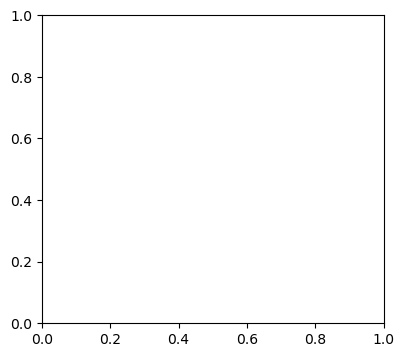

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

# Charger les données
data = np.load("chi2_grids.npz")
omega_m0_vals = data["omega_m0_vals"]
sigma8_0_vals = data["sigma8_0_vals"]
w_vals = data["w_vals"]

chi2_grid_om_sig8 = data["chi2_grid_om_sig8"]
chi2_grid_om_w = data["chi2_grid_om_w"]
chi2_grid_sig8_w = data["chi2_grid_sig8_w"]

plt.figure(figsize=(15, 4))

sigma_labels = [r'1$\sigma$', r'2$\sigma$', r'3$\sigma$', r'min $\chi^2 grid$',r'min $\chi^2$ bf']

# Plan (omega_m0, sigma8_0)
plt.subplot(1, 3, 1)
plt.plot(omega_m0_fit, sigma8_0_fit, 'o', color="green", label='Best-fit')
plt.axvline(omega_m0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(sigma8_0_fit, color='green', linestyle='--', alpha=0.5)

plot_contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_sig8, r"$\Omega_m$", r"$\sigma_{8}^{0}$", r"$\Omega_m$ vs $\sigma_{8}^{0}$")

# Plan (omega_m0, w)
plt.subplot(1, 3, 2)

custom_lines = [
    Line2D([0], [0], color='white', lw=1),
    Line2D([0], [0], color='green', lw=1),
    Line2D([0], [0], color='red', lw=1),
    Line2D([0], [0], color='red', marker='o', lw=0),
    Line2D([0], [0], color='green', marker='o', lw=0)
]

plt.plot(omega_m0_fit, w_fit, 'o', color="green")
plt.axvline(omega_m0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(w_fit, color='green', linestyle='--', alpha=0.5)
legend = plt.legend(custom_lines, sigma_labels, loc='upper right', frameon=True)
legend.get_frame().set_facecolor('grey')  
plot_contour(omega_m0_vals, w_vals, chi2_grid_om_w, r"$\Omega_m$", r"w", r"$\Omega_m$ vs $w$")


# Plan (sigma8_0, w)
plt.subplot(1, 3, 3)
plt.plot(sigma8_0_fit, w_fit,'o',color="green", label='Best-fit')
plt.axvline(sigma8_0_fit, color='green', linestyle='--', alpha=0.5)
plt.axhline(w_fit, color='green', linestyle='--', alpha=0.5)
plot_contour(sigma8_0_vals, w_vals, chi2_grid_sig8_w,r"$\sigma_{8}^{0}$",r"$w$", r"$\sigma_{8}^{0}$ vs w")

plt.tight_layout()
plt.show()


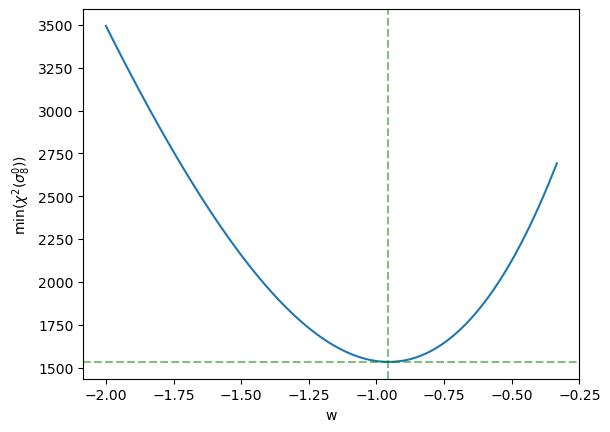

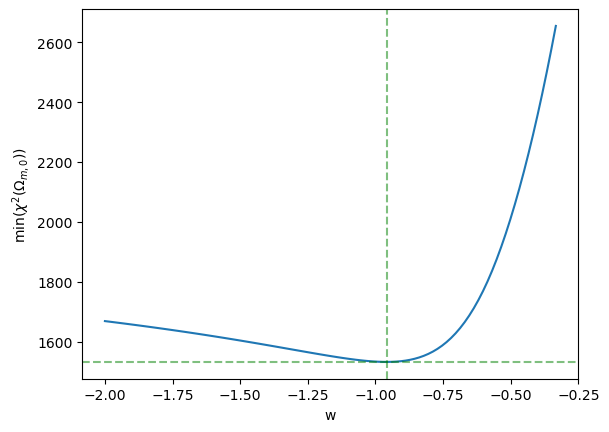

In [ ]:
plot_Chi2_w(omega_m0_vals,w_vals,chi2_grid_om_w,"w",r"min$(\chi^2(\sigma_8^0))$")
plt.show()
plot_Chi2_w(sigma8_0_vals,w_vals,chi2_grid_sig8_w,"w",r"min$(\chi^2(\Omega_{m,0}))$")
plt.show()